In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.2 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 6.1 MB/s eta 0:00:00


In [5]:
class DroneDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask) 
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
       
        mask = torch.from_numpy(mask).long()
        
        if self.patches:
            img, mask = self.tiles(img, mask)
            
        return img, mask
    
    def tiles(self, img, mask):

       
        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768)
     
        img_patches = img_patches.contiguous().view(3,-1, 512, 768)
        
        img_patches = img_patches.permute(1,0,2,3)
        
   
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)
        
        return img_patches, mask_patches

In [7]:
IMAGE_PATH = '../input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/'
MASK_PATH = '../input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/'

In [8]:
n_classes = 23 


def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  400


In [9]:
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  306
Val Size     :  54
Test Size    :  40


Image Size (4000, 6000, 3)
Mask Size (4000, 6000)


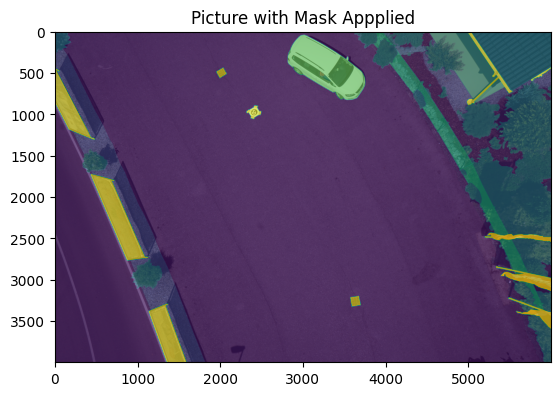

In [10]:
img = Image.open(IMAGE_PATH + df['id'][100] + '.jpg')
mask = Image.open(MASK_PATH + df['id'][100] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

In [11]:
class DroneDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask) 
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        
        mask = torch.from_numpy(mask).long()
        
        if self.patches:
            img, mask = self.tiles(img, mask)
            
        return img, mask
    
    def tiles(self, img, mask):

        
        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768)
        
        img_patches = img_patches.contiguous().view(3,-1, 512, 768)
      
        img_patches = img_patches.permute(1,0,2,3)
        
      
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)
        
        return img_patches, mask_patches

In [12]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]


t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])


train_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

batch_size= 3

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

In [13]:
model = smp.Unet(
    'resnet50',                 
    encoder_weights='imagenet',  
    classes=23,                  
    activation=None,             
    encoder_depth=5,             
    decoder_channels=[256, 128, 64, 32, 16] 
)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 240MB/s]


In [14]:
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [15]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1) 
        correct = torch.eq(output, mask).int() 
        accuracy = float(correct.sum()) / float(correct.numel()) 
    return accuracy

In [16]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

       
        iou_per_class = []
        for clas in range(0, n_classes): 
            true_class = pred_mask == clas 
            true_label = mask == clas 
            
            
            if true_label.long().sum().item() == 0:
                iou_per_class.append(np.nan)
            
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union + smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [17]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    
    
    torch.cuda.empty_cache()
   
    train_losses = []
    test_losses = []
   
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []

    lrs = []
   
    min_loss = np.inf
 
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    
  
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        
       
        model.train() 
        for i, data in enumerate(tqdm(train_loader)):
            image_tiles, mask_tiles = data 
           
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()
                image_tiles = image_tiles.view(-1, c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
           
            image = image_tiles.to(device); mask = mask_tiles.to(device);
           
            output = model(image)
            loss = criterion(output, mask)
    
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            
       
            loss.backward()
            optimizer.step() 
            optimizer.zero_grad() 
            
       
            lrs.append(get_lr(optimizer))
           
            scheduler.step() 
         
            running_loss += loss.item()
            
        else:
            
            model.eval()
            
          
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
    
            
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    image_tiles, mask_tiles = data
                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()
                        image_tiles = image_tiles.view(-1, c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    
                    val_iou_score += mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))

            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
               
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-ResNet50_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

           
            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                print(f'Loss Not Decrease for {not_improve} time')
               
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
   
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
           
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
   
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [18]:
max_lr = 1e-3 
epoch = 15 
weight_decay = 1e-4 

criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay) 
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))


history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 1.845 
Epoch:1/15.. Train Loss: 2.708.. Val Loss: 1.845.. Train mIoU:0.074.. Val mIoU: 0.162.. Train Acc:0.288.. Val Acc:0.658.. Time: 4.19m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.845 >> 1.261 
Epoch:2/15.. Train Loss: 1.793.. Val Loss: 1.261.. Train mIoU:0.139.. Val mIoU: 0.162.. Train Acc:0.600.. Val Acc:0.701.. Time: 3.91m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.261 >> 1.211 
Epoch:3/15.. Train Loss: 1.453.. Val Loss: 1.211.. Train mIoU:0.137.. Val mIoU: 0.174.. Train Acc:0.612.. Val Acc:0.674.. Time: 3.94m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.211 >> 1.174 
saving model...
Epoch:4/15.. Train Loss: 1.385.. Val Loss: 1.174.. Train mIoU:0.143.. Val mIoU: 0.168.. Train Acc:0.601.. Val Acc:0.657.. Time: 3.95m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.174 >> 1.069 
Epoch:5/15.. Train Loss: 1.294.. Val Loss: 1.069.. Train mIoU:0.160.. Val mIoU: 0.183.. Train Acc:0.622.. Val Acc:0.703.. Time: 3.95m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.069 >> 1.033 
Epoch:6/15.. Train Loss: 1.197.. Val Loss: 1.033.. Train mIoU:0.172.. Val mIoU: 0.186.. Train Acc:0.652.. Val Acc:0.711.. Time: 3.93m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.033 >> 0.893 
Epoch:7/15.. Train Loss: 1.096.. Val Loss: 0.893.. Train mIoU:0.194.. Val mIoU: 0.215.. Train Acc:0.679.. Val Acc:0.734.. Time: 3.95m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:8/15.. Train Loss: 1.020.. Val Loss: 0.961.. Train mIoU:0.210.. Val mIoU: 0.221.. Train Acc:0.697.. Val Acc:0.731.. Time: 3.95m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.893 >> 0.851 
Epoch:9/15.. Train Loss: 0.968.. Val Loss: 0.851.. Train mIoU:0.222.. Val mIoU: 0.226.. Train Acc:0.711.. Val Acc:0.747.. Time: 3.95m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.851 >> 0.694 
saving model...
Epoch:10/15.. Train Loss: 0.856.. Val Loss: 0.694.. Train mIoU:0.248.. Val mIoU: 0.266.. Train Acc:0.745.. Val Acc:0.792.. Time: 3.94m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.694 >> 0.666 
Epoch:11/15.. Train Loss: 0.806.. Val Loss: 0.666.. Train mIoU:0.256.. Val mIoU: 0.260.. Train Acc:0.762.. Val Acc:0.789.. Time: 3.94m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.666 >> 0.630 
Epoch:12/15.. Train Loss: 0.740.. Val Loss: 0.630.. Train mIoU:0.270.. Val mIoU: 0.281.. Train Acc:0.780.. Val Acc:0.806.. Time: 3.94m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.630 >> 0.600 
Epoch:13/15.. Train Loss: 0.697.. Val Loss: 0.600.. Train mIoU:0.285.. Val mIoU: 0.289.. Train Acc:0.795.. Val Acc:0.816.. Time: 3.95m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.600 >> 0.595 
Epoch:14/15.. Train Loss: 0.658.. Val Loss: 0.595.. Train mIoU:0.295.. Val mIoU: 0.301.. Train Acc:0.806.. Val Acc:0.818.. Time: 3.94m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.595 >> 0.592 
saving model...
Epoch:15/15.. Train Loss: 0.636.. Val Loss: 0.592.. Train mIoU:0.305.. Val mIoU: 0.303.. Train Acc:0.815.. Val Acc:0.816.. Time: 3.96m
Total time: 59.39 m


In [19]:
torch.save(model, 'Unet-ResNet50.pt')

In [20]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot(history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    

def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()


def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

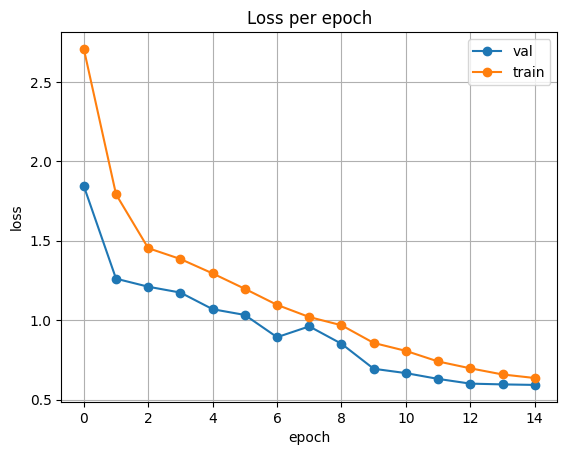

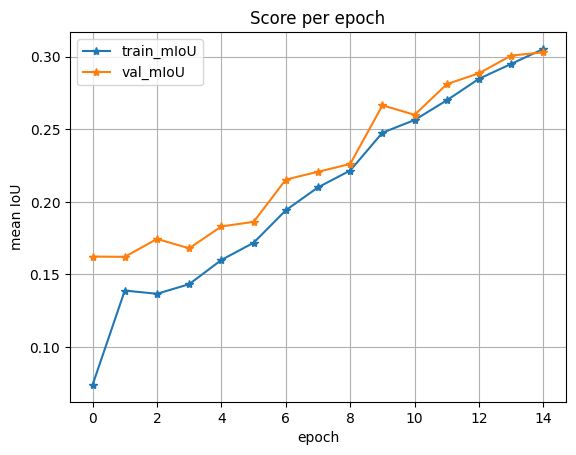

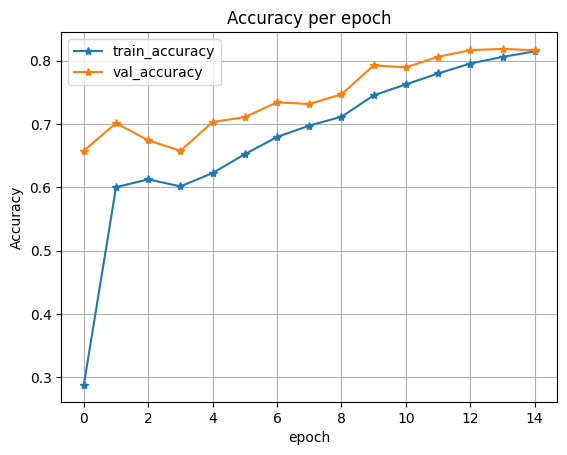

In [21]:
plot_loss(history)
plot_score(history)
plot_acc(history)

In [22]:
class DroneTestDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        return img, mask

t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)

test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

In [23]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
   
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
   
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
     
        score = mIoU(output, mask)
      
        masked = torch.argmax(output, dim=1)
      
        masked = masked.cpu().squeeze(0)
    return masked, score

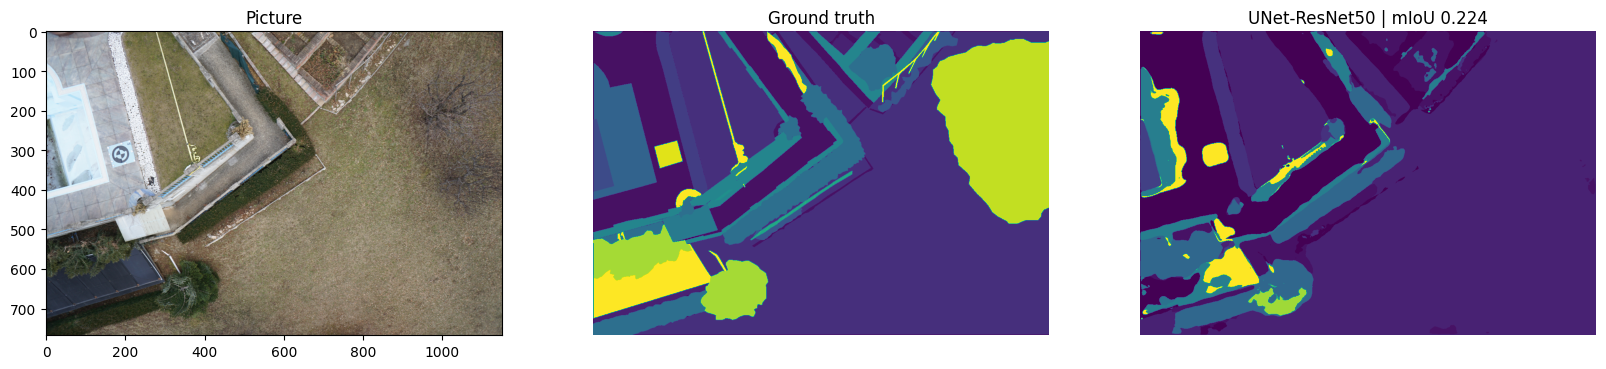

In [24]:
image1, mask1 = test_set[2]
pred_mask1, score1 = predict_image_mask_miou(model, image1, mask1)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image1)
ax1.set_title('Picture');

ax2.imshow(mask1)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask1)
ax3.set_title('UNet-ResNet50 | mIoU {:.3f}'.format(score1))
ax3.set_axis_off()

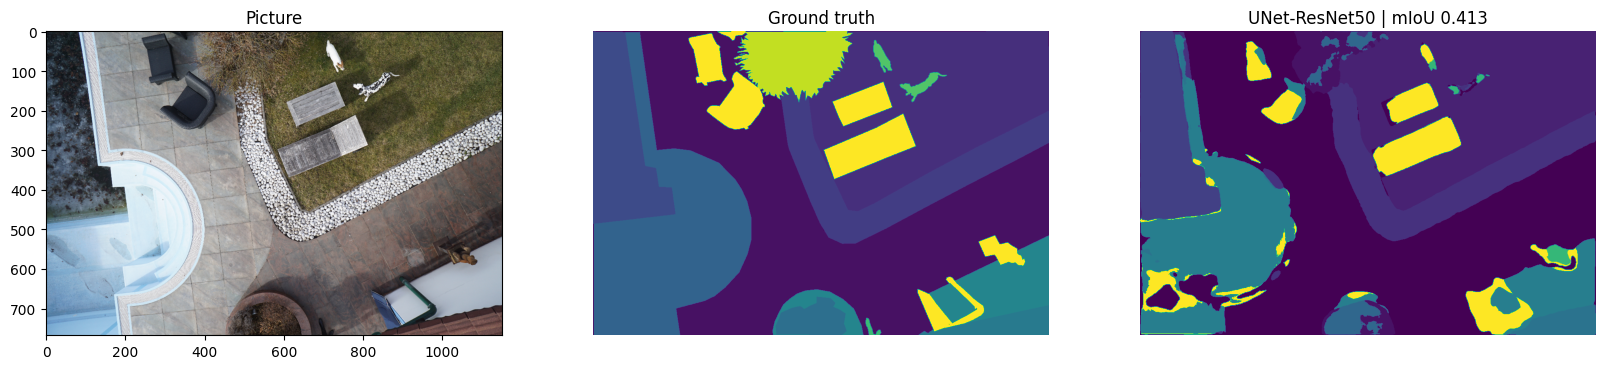

In [25]:
image2, mask2 = test_set[4]
pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image2)
ax1.set_title('Picture');

ax2.imshow(mask2)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask2)
ax3.set_title('UNet-ResNet50 | mIoU {:.3f}'.format(score2))
ax3.set_axis_off()

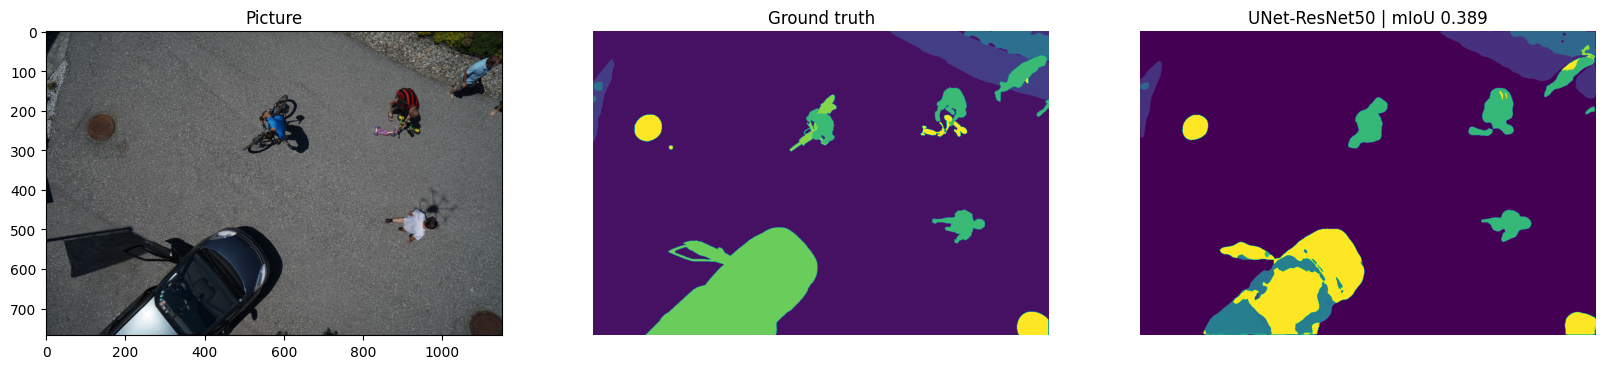

In [26]:
image3, mask3 = test_set[6]
pred_mask3, score3 = predict_image_mask_miou(model, image3, mask3)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image3)
ax1.set_title('Picture');

ax2.imshow(mask3)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask3)
ax3.set_title('UNet-ResNet50 | mIoU {:.3f}'.format(score3))
ax3.set_axis_off()


In [27]:
def miou_list(model, test_set):
    score_miou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_miou.append(score)
    return score_miou

In [28]:
test_miou_list = miou_list(model, test_set)

  0%|          | 0/40 [00:00<?, ?it/s]

In [29]:
def predict_image_mask_pixel_accuracy(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        
        pix_acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, pix_acc

In [30]:
def pixel_accuracy_list(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel_accuracy(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [31]:
test_pixel_accuracy_list = pixel_accuracy_list(model, test_set)

  0%|          | 0/40 [00:00<?, ?it/s]

In [32]:
print('Test Set mIoU', np.mean(test_miou_list))

Test Set mIoU 0.335304318589858


In [33]:
print('Test Set Pixel Accuracy', np.mean(test_pixel_accuracy_list))

Test Set Pixel Accuracy 0.793904933223018


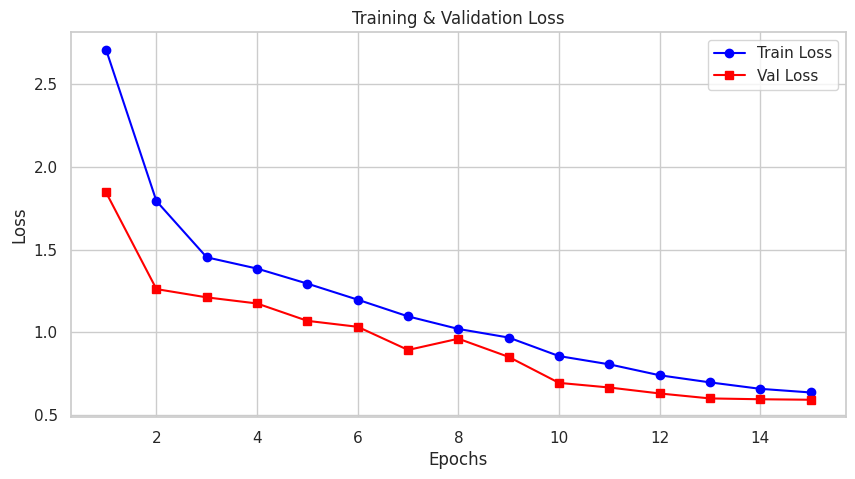

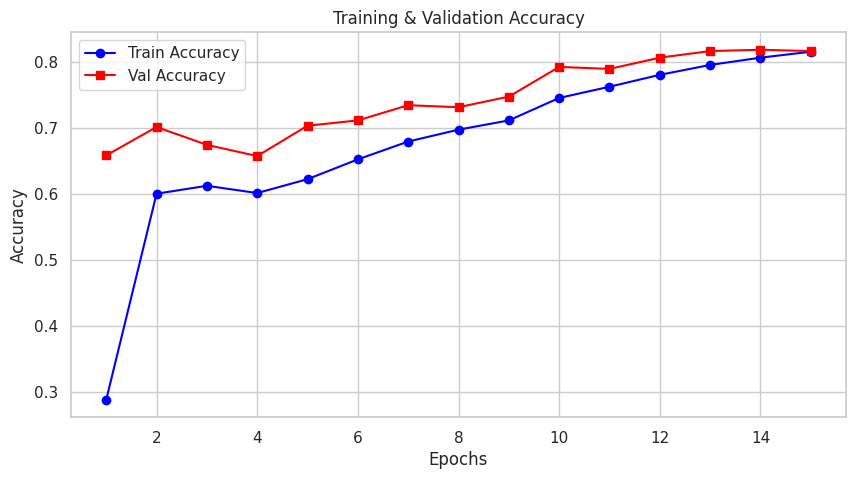

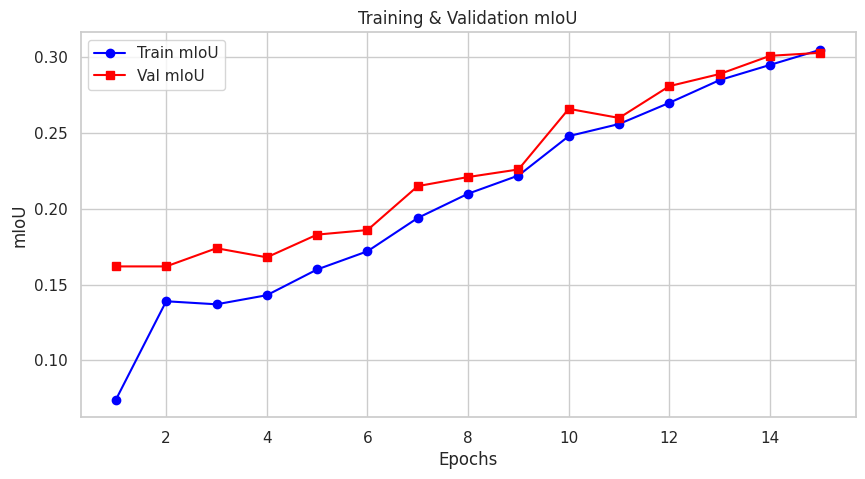

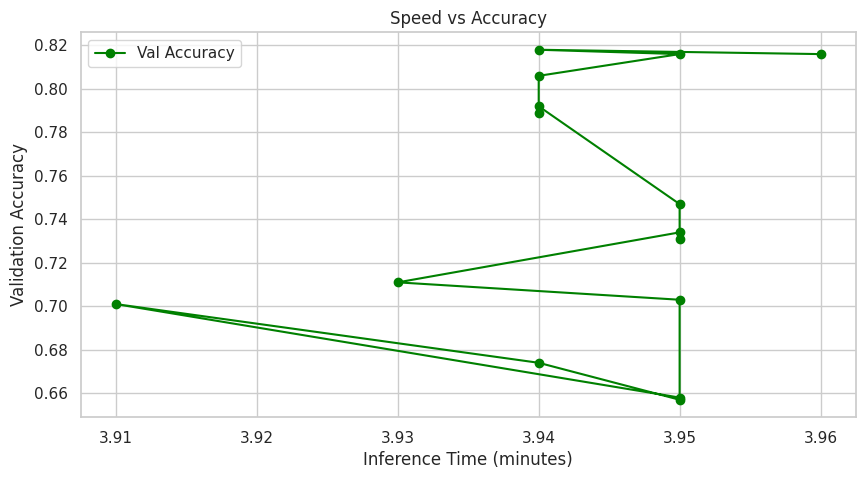

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data extracted from logs
epochs = np.arange(1, 16)  # 15 epochs

train_loss = [2.708, 1.793, 1.453, 1.385, 1.294, 1.197, 1.096, 1.020, 0.968, 0.856, 0.806, 0.740, 0.697, 0.658, 0.636]
val_loss = [1.845, 1.261, 1.211, 1.174, 1.069, 1.033, 0.893, 0.961, 0.851, 0.694, 0.666, 0.630, 0.600, 0.595, 0.592]

train_acc = [0.288, 0.600, 0.612, 0.601, 0.622, 0.652, 0.679, 0.697, 0.711, 0.745, 0.762, 0.780, 0.795, 0.806, 0.815]
val_acc = [0.658, 0.701, 0.674, 0.657, 0.703, 0.711, 0.734, 0.731, 0.747, 0.792, 0.789, 0.806, 0.816, 0.818, 0.816]

train_miou = [0.074, 0.139, 0.137, 0.143, 0.160, 0.172, 0.194, 0.210, 0.222, 0.248, 0.256, 0.270, 0.285, 0.295, 0.305]
val_miou = [0.162, 0.162, 0.174, 0.168, 0.183, 0.186, 0.215, 0.221, 0.226, 0.266, 0.260, 0.281, 0.289, 0.301, 0.303]

inference_time = [3.95, 3.91, 3.94, 3.95, 3.95, 3.93, 3.95, 3.95, 3.95, 3.94, 3.94, 3.94, 3.95, 3.94, 3.96]

sns.set(style="whitegrid")

# Loss Plot
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, 'o-', label="Train Loss", color='blue')
plt.plot(epochs, val_loss, 's-', label="Val Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()

# Accuracy Plot
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, 'o-', label="Train Accuracy", color='blue')
plt.plot(epochs, val_acc, 's-', label="Val Accuracy", color='red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.show()

# mIoU Plot
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_miou, 'o-', label="Train mIoU", color='blue')
plt.plot(epochs, val_miou, 's-', label="Val mIoU", color='red')
plt.xlabel("Epochs")
plt.ylabel("mIoU")
plt.title("Training & Validation mIoU")
plt.legend()
plt.show()

# Inference Time vs Accuracy
plt.figure(figsize=(10, 5))
plt.plot(inference_time, val_acc, 'o-', label="Val Accuracy", color='green')
plt.xlabel("Inference Time (minutes)")
plt.ylabel("Validation Accuracy")
plt.title("Speed vs Accuracy")
plt.legend()
plt.show()
